<a href="https://colab.research.google.com/github/google/making_with_ml/blob/master/sports_ai/Sports_AI_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analyzing My Tennis Serve with Machine Learning

In this notebook, we'll use the Video Intelligence API to analyze a tennis serve, including the angle of the arms and legs during the serve. 

We'll also build a custom model to track the speed of a tennis ball after being served.

##Setup

First, let's install the libraries. This first cell will download and install the libraries on our colab virtual machine, and the next cell imports them.

In [ ]:
!pip install google-cloud-automl
!apt-get install libmagickwand-dev
!pip install pillow
!pip install --upgrade protobuf
!pip install --upgrade google-cloud-videointelligence

You might have to restart your runtime to load these packages.

In [ ]:
import sys
import os
import json
import math

from google.colab import auth
from google.colab import files

import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np

from google.cloud import automl
from google.cloud import videointelligence_v1p3beta1 as videointelligence
from google.oauth2 import service_account

Next, create a new GCP account (if you don't have one already), and create a new project. 

In [ ]:
auth.authenticate_user()

Fill in your info below by specifying your project id. You'll also need to choose a bucket name (that should start with `gs://`) and a name for your service account, a file that will be downloaded to this notebook to allow us to use the AutoML API. `service_account_name` can be anything.

In [ ]:
# TODO: REMOVE MY SPECIFIC CONFIG
project_id = 'YOUR_PROJECT_ID'  #@param {type: "string"}
bucket = 'gs://YOUR_BUCKET' #@param {type: "string"}
service_account_name="ANY_RANDOM_NAME" #@param {type: "string"}

In [ ]:
!gcloud config set project {project_id}
!gsutil mb {bucket}
!gcloud iam service-accounts create {service_account_name}
!gcloud iam service-accounts keys create ./key.json --iam-account {service_account_name}@{project_id}.iam.gserviceaccount.com

# Enable the Video Intelligence API and AutoML
!gcloud services enable videointelligence.googleapis.com
!gcloud services enable automl.googleapis.com

# Give your service account permission to access the API
!gcloud projects add-iam-policy-binding {project_id} --member="serviceAccount:{service_account_name}@{project_id}.iam.gserviceaccount.com" --role="roles/editor"

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./key.json"

##Using the Video Intelligence API

In this bit, we'll analyze our skeletons using the Video Intelligence API. The API tracks all sorts of features, including features of the face, but we'll just focus on the body:

![alt text](https://github.com/google/making_with_ml/blob/master/sports_ai/assets/posture_tracking.gif?raw=true))

To do this, you'll need to upload a video you'd like to analyze to a cloud storage bucket. The fastest way to do this is from the command line: `gsutil cp YOUR_VIDEO_FILE.mp4 gs://YOUR_BUCKET_NAME`. Fill in the name of the file you upload here:

In [ ]:
file_to_analyze = 'YOUR_SPORTS_VIDEO.mp4' #@param {type: "string"}

In [ ]:
# Verify that you see that file listed here... 
# This cell should print the name of the file you just uploaded
!gsutil ls {bucket}/{file_to_analyze}

Now let's run the Video Intelligence API's Person Detection feature on the uploaded video. We pass this function the input path to our file in cloud storage as well as an output path where we'd like the results to be written. 

In [ ]:
input_uri = os.path.join(bucket, file_to_analyze)
output_uri = os.path.join(bucket, 'output.json')

In [ ]:
# This function comes from the docs
# https://cloud.google.com/video-intelligence/docs/people-detection
def detect_person(input_uri, output_uri):
    """Detects people in a video."""

    client = videointelligence.VideoIntelligenceServiceClient(credentials=service_account.Credentials.from_service_account_file(
    './key.json'))

    # Configure the request
    config = videointelligence.types.PersonDetectionConfig(
        include_bounding_boxes=True,
        include_attributes=True,
        include_pose_landmarks=True,
    )
    context = videointelligence.types.VideoContext(person_detection_config=config)

    # Start the asynchronous request
    operation = client.annotate_video(
        input_uri=input_uri,
        output_uri=output_uri,
        features=[videointelligence.enums.Feature.PERSON_DETECTION],
        video_context=context,
    )

    return operation


In [ ]:
# If you get a permissions episode here, you might have to modify the permissions
# on your bucket to allow your service account to access it. Do that in the 
# GCP storage console/UI.
operation = detect_person(input_uri, output_uri)

We've called an asynchronous function here--`detect_person`--because long videos can take a while to analyze. You can check the status of the analysis by calling `operation.done`:

In [ ]:
print(f"Operation ${operation.operation.name} is done? {operation.done()}")

Note that even if you restart this notebook, the Video Intelligence API will still be analyzing your video in the cloud! So you won't lose any progress.

Once the operation is finished, we can download the results from our cloud storage bucket:

In [ ]:
# Note! This won't work unless operation.done() == True!
!mkdir tmp
!gsutil cp {output_uri} tmp

## Formatting the Data

Results are written to cloud storage as a json file. Let's load them!

In [ ]:
data = json.load(open('./tmp/output.json'))

These json files are usually pretty big, so don't print them! Instead, let's just inspect the structure:

In [ ]:
print(data.keys())
# We only care about annotation_results[0] because we only have one video
print(len(data['annotation_results'][0]['person_detection_annotations']))

dict_keys(['annotation_results'])
7


It's easy to get lost in all these nested fields! What we really want is the data stored in `data['annotation_results`][0][`person_detection_annotations`]. Let's grab it:

In [ ]:
people_annotations = data['annotation_results'][0]['person_detection_annotations']

In `people_annotations`, every entry correspond to a person and each person has a unique set of `tracks`, or tracked segments. We'll use a helper function to parse through the data and rearrange it to make it easier to use for our analyses:

In [ ]:
'''
This helper function takes in a person and rearranges the data so it's in 
a timeline, which will make it easier for us to work with
'''
def analyzePerson(person):
  frames = []
  for track in person['tracks']:
    # Convert timestamps to seconds
    for ts_obj in track['timestamped_objects']:
      time_offset = ts_obj['time_offset']
      timestamp = 0
      if 'nanos' in time_offset:
        timestamp += time_offset['nanos'] / 10**9
      if 'seconds' in time_offset:
        timestamp += time_offset['seconds']
      if 'minutes' in time_offset:
        timestamp += time_offset['minutes'] * 60
      frame= {'timestamp' : timestamp}
      for landmark in ts_obj['landmarks']:
        frame[landmark['name'] + '_x'] = landmark['point']['x']
        # Subtract y value from 1 because positions are calculated
        # from the top left corner
        frame[landmark['name'] + '_y'] = 1 - landmark['point']['y']
      frames.append(frame)
  sorted(frames, key=lambda x: x['timestamp'])
  return frames

We'll also store the data in a pandas DataFrame (also for convenience), and sort each data point by timestamp

In [ ]:
annotationsPd = pd.DataFrame(analyzePerson(people_annotations[0]))
for annotation in people_annotations[1:]:
  annotationsPd = annotationsPd.append(pd.DataFrame(analyzePerson(annotation)))

annotationsPd = annotationsPd.sort_values('timestamp', ascending=True)

Phew! The hard bit (parsing the data) is over. Now we can take a look at the results!

In [ ]:
annotationsPd.head()

,timestamp,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,left_ear_x,left_ear_y
0,0.0000,0.249406,0.550609,0.249406,0.555926,0.244419,0.555926,0.233447,0.548836,0.254393,0.513386,0.223473,0.506296,0.270352,0.477936,0.232450,0.456666,0.273345,0.476164,0.259381,0.469074,0.255391,0.403491,0.231452,0.401718,0.260378,0.320183,0.226465,0.320183,0.266363,0.245738,0.220480,0.243966,NaN,NaN
1,0.1001,0.249679,0.549700,0.249679,0.556771,0.244704,0.555003,0.233761,0.549700,0.255648,0.514343,0.223813,0.505503,0.271565,0.480753,0.233761,0.459539,0.264601,0.480753,0.259627,0.471914,0.255648,0.402968,0.231772,0.401200,0.260622,0.321646,0.226798,0.319878,0.266591,0.245628,0.219834,0.243860,NaN,NaN
2,0.2002,0.249887,0.552339,0.249887,0.557653,0.244902,0.555882,0.234934,0.548796,0.255868,0.516910,0.224965,0.508053,0.273811,0.486795,0.236928,0.461995,0.278795,0.488566,0.261849,0.476166,0.254871,0.403537,0.231943,0.401765,0.259855,0.322049,0.225962,0.320278,0.265836,0.244105,0.219981,0.244105,NaN,NaN
3,0.3003,0.251422,0.553982,0.251422,0.559314,0.246421,0.557536,0.235420,0.550428,0.257422,0.516661,0.227419,0.507775,0.276424,0.486448,0.239421,0.463344,0.284424,0.482894,0.266423,0.472230,0.254422,0.404696,0.231420,0.402919,0.259422,0.321168,0.226419,0.321168,0.265423,0.246525,0.220419,0.244747,NaN,NaN
4,0.4004,0.252638,0.551109,0.253662,0.558381,0.247523,0.556563,0.237291,0.551109,0.257754,0.514745,0.228083,0.511108,0.278217,0.478380,0.238314,0.458380,0.292542,0.474744,0.263893,0.456562,0.253662,0.405652,0.230129,0.403834,0.258777,0.322015,0.225013,0.322015,0.265939,0.247468,0.219897,0.245650,NaN,NaN


As you can see above, we've organized the data by the position of each body part by timestamp. Note that this works because they're actually only one person in my video--me!

## Plotting the Data

The first thing you might want to do is plot the positions of various body parts over time. Since I was analyzing a bunch of shots of my serve, I thought I'd look at the position of my wrists to try to determine the start and end time of a serve. Try replacing wrist values for anything else you're interested in tracking:

<Figure size 432x288 with 0 Axes>

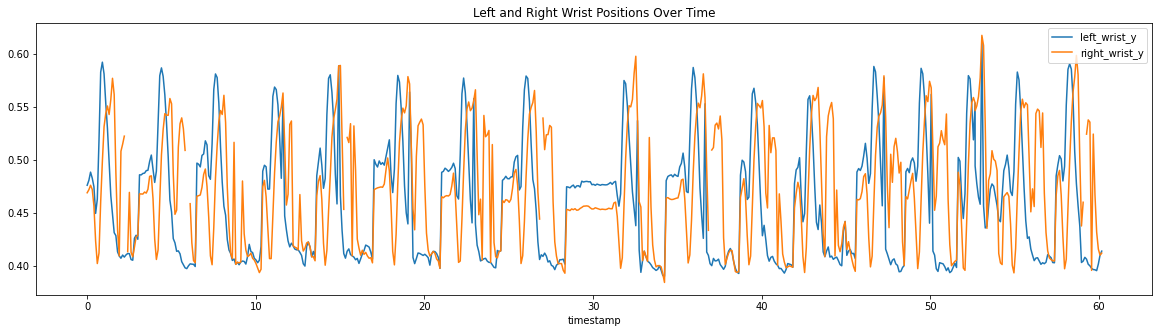

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['left_wrist_y', 'right_wrist_y'], figsize=(20, 5))
plt.title("Left and Right Wrist Positions Over Time")
plt.savefig("wrist_pos")

From the plot above, you can actually identify the time of my serve pretty easily! First, I throw the tennis ball up with my left hand (peak in left wrist). Then, a few seconds later, I hit the ball with my racket (peak in right wrist y).

The above plot is sort of useful, but what would be even better would be understanding the angles of my elbow, knee, etc. 

## Computing Angles
Step 1: let's create some classes for making working with points easier:

In [ ]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y 

To compute the angle made by three points, we use the [Law of Cosines](https://www.google.com/search?q=rule+of+cosines&oq=rule+of+cosines&aqs=chrome.0.0l8.1048j1j7&sourceid=chrome&ie=UTF-8#wptab=s:H4sIAAAAAAAAAONgVuLQz9U3SMkuLnjE6Mgt8PLHPWEpi0lrTl5jNOLiCs7IL3fNK8ksqRRS4WKDsqS4eKTgmjQYpLi44DyeXUyCzvl5yakFJc6JOcmlOYkl-UWLWCV9EssV8tMUkvOLM_NSixWS4XIALyw914AAAAA). Did you forget about this? I did! Imagine a triangle with side lengths a, b, and c. Then, to find 𝛾 (the angle across from side c), the formula is:

\begin{equation*}
\gamma = \cos^{-1}\frac{a^2+b^2 - c^2}{2ab}
\end{equation*}

There's a good explanation and code sample [here](https://medium.com/@manivannan_data/find-the-angle-between-three-points-from-2d-using-python-348c513e2cd), from which this function is borrowed:

In [ ]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c.y-b.y, c.x-b.x) - math.atan2(a.y-b.y, a.x-b.x))
    return ang

Let's compute some useful angles below

In [ ]:
def computeElbowAngle(row, which='right'):
  wrist = Point(row[f'{which}_wrist_x'], row[f'{which}_wrist_y'])
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  return getAngle(wrist, elbow, shoulder)

def computeShoulderAngle(row, which='right'):
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  return getAngle(hip, shoulder, elbow)

def computeKneeAngle(row, which='right'):
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  knee = Point(row[f'{which}_knee_x'], row[f'{which}_knee_y'])
  ankle = Point(row[f'{which}_ankle_x'], row[f'{which}_ankle_y'])
  return getAngle(ankle, knee, hip)

In [ ]:
# For a single timeslot...
row = annotationsPd.iloc[-1]
print("Elbow angle: " + str(computeElbowAngle(row)))
print("Shoulder angle: " + str(computeShoulderAngle(row)))
print("Knee angle: " + str(computeKneeAngle(row)))

Elbow angle: 159.1770209504165
Shoulder angle: 1.0746399753283846
Knee angle: 186.0335583151575


Sweet! Now let's plot those angles over time.

In [ ]:
annotationsPd['right_elbow_angle'] = annotationsPd.apply(computeElbowAngle, axis=1)
annotationsPd['right_shoulder_angle'] = annotationsPd.apply(computeShoulderAngle, axis=1)
annotationsPd['right_knee_angle'] = annotationsPd.apply(computeKneeAngle, axis=1)

Now let's plot the results!

<Figure size 432x288 with 0 Axes>

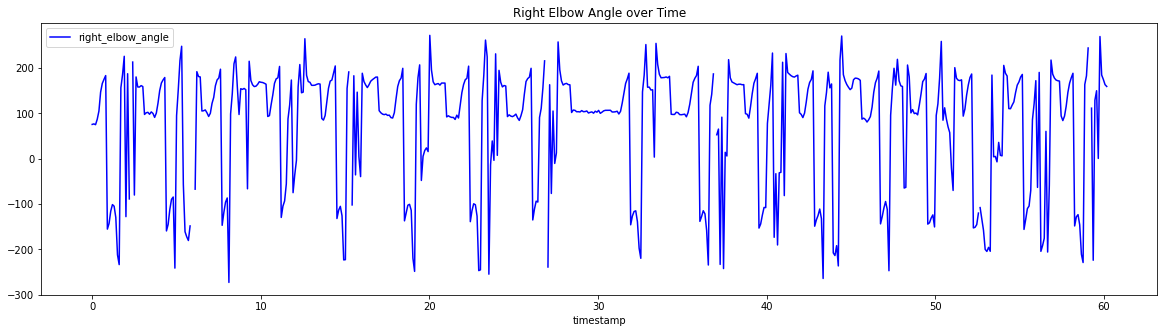

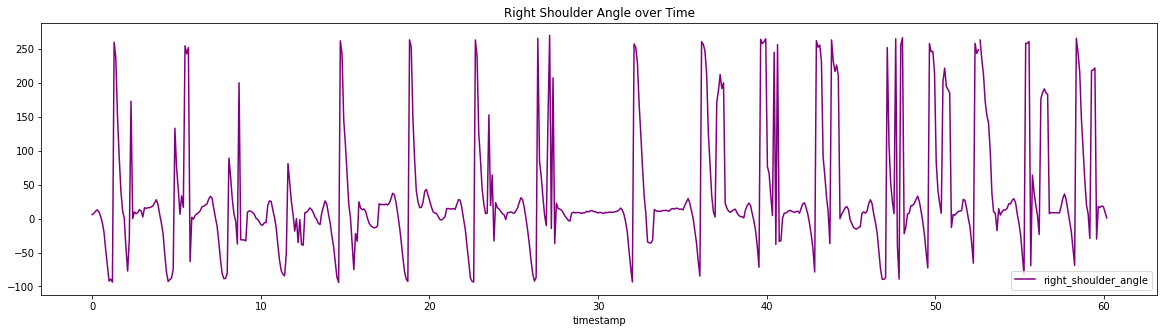

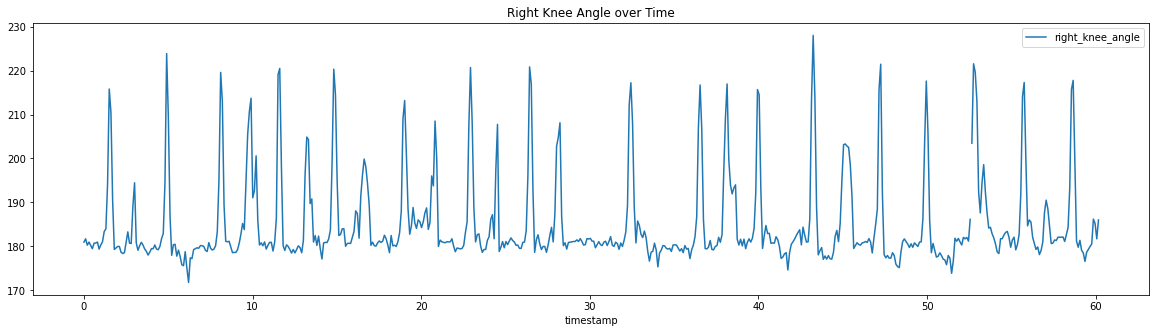

In [ ]:
plt.figure()
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), color='blue')
plt.title("Right Elbow Angle over Time")
plt.savefig("right_elbow_angle")
annotationsPd.plot('timestamp', ['right_shoulder_angle'], figsize=(20, 5), color='purple')
plt.title("Right Shoulder Angle over Time")
plt.savefig("right_shoulder_angle")
annotationsPd.plot('timestamp', ['right_knee_angle'], figsize=(20, 5))
plt.title("Right Knee Angle over Time")
plt.savefig("right_knee_angle")

Now, these angles might not be very useful on their own. But when we combine them with position data, we can tell what the angle of my arm was _at the height of my serve_. In particular, let's take a look at the angle of my elbow and shoulder when my right wrist was at the highest point in the serve.

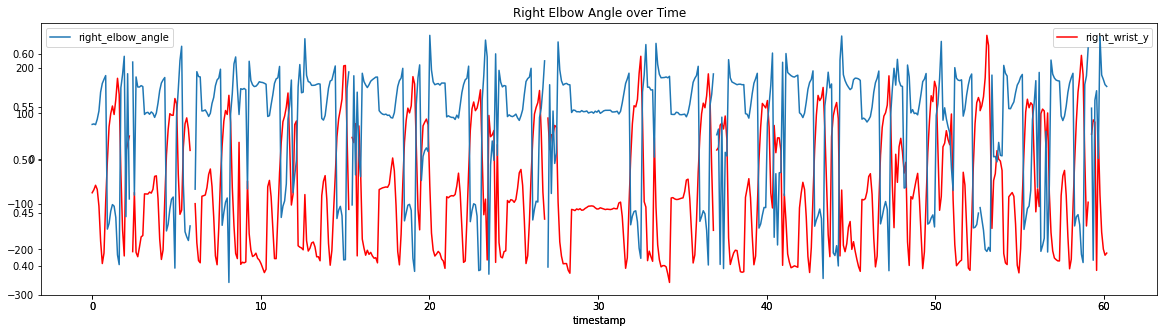

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(111, label="1")
annotationsPd.plot('timestamp', ['right_wrist_y'], figsize=(20, 5), ax=ax, color='red')
plt.title("Right Elbow Angle over Time")

ax2=fig.add_subplot(111, label="2", frame_on=False)
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), ax=ax2)

#annotationsPd.plot.scatter('right_wrist_y', 'right_elbow_angle')

These charts might be difficult to read, but but they tell me that when my arm is most extended, the angle of my elbow is about a 200 degree angle.

# Tracking the Speed of the Ball With AutoML

To compute the speed of the ball, I used [AutoML Vision Object Detection](https://cloud.google.com/vision/automl/object-detection/docs), a GUI-based way to train a deep neural network. Check out the [blog post](https://daleonai.com/machine-learning-for-sports) to see how I trained the model. Here, we'll just use it.

Since we've trained a vision model, we'll first need to convert our video into images. First, upload a video file:

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving tennis_serves_half.mp4 to tennis_serves_half.mp4
User uploaded file "tennis_serves_half.mp4" with length 71498775 bytes


Next, we'll use a command line tool called ffmpeg to conver the video into photos, 10 photos per second.

In [ ]:
filename, _ = uploaded.popitem()

Below, I use the ffmpeg command to generate snapshots from my video at 20 frames per second. I take a 2 second segment (`-t 00:00:02`) that starts from one second in (`-ss 00:00:01`). This aligns with my first serve.

In [ ]:
!mkdir tmp/snapshots
!ffmpeg -i {filename} -vf fps=20 -ss 00:00:01 -t 00:00:02 tmp/snapshots/%03d.jpg

mkdir: cannot create directory ‘tmp/snapshots’: File exists
mkdir: cannot create directory ‘tmp/snapshots’: File exists
ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable

Now let's analyze those snapshots. Grab your AutoML model id:

In [ ]:
model_id = 'IOD6154100721080860672' #@param {type: "string"}

In [ ]:
def getAutoMLPrediction(filename):
  with open(filename, 'rb') as ff:
      content = ff.read()
      prediction_client = automl.PredictionServiceClient()

      name = 'projects/{}/locations/us-central1/models/{}'.format(project_id, model_id)
      params = {"score_threshold": "0.7"} # this metric changes the sensitivity of your model
      image = automl.types.Image(image_bytes=content)
      payload = automl.types.ExamplePayload(image=image)
      return prediction_client.predict(name, payload, params)

In [ ]:
def getBallsCoords(filename):
  res = getAutoMLPrediction(filename)
  return [obj.image_object_detection.bounding_box.normalized_vertices for obj in res.payload]

In [ ]:
snapshotFiles = os.listdir('tmp/snapshots')
snapshotFiles.sort()
print(f"Analyzing {len(snapshotFiles)} images")

Analyzing 40 images


Now that we're able to track the ball, let's make a pretty image so we can see what's actually going on:

In [ ]:
def makeBallImage(filename, coords):
  im = Image.open(filename)
  im.thumbnail((im.width * 0.2, im.height * 0.2))
  draw = ImageDraw.Draw(im)
  for coord in coords:
    draw.rectangle([(coord[0].x * im.width, coord[0].y * im.height), coord[1].x * im.width, coord[1].y * im.height])
  return im

In [ ]:
# Call the AutoML API--this could take a while!
coords = [getBallsCoords('tmp/snapshots/' + filename) for filename in snapshotFiles if 'jpg' in filename]

In [ ]:
imgs = [makeBallImage('tmp/snapshots/' + filename, coord) for filename, coord in zip(snapshotFiles, coords) if 'jpg' in filename]
!mkdir snapshot_annotated
for idx, im in enumerate(imgs):
  plt.imshow(np.asarray(im))
  plt.savefig('snapshot_annotated/file%d.png' % idx)
  
# Create a cute video of your seves!
!ffmpeg -framerate 20 -i snapshot_annotated/file%01d.png -vcodec mpeg4 -y ball_tracking.mp4
!ffmpeg -i ball_tracking.mp4 ball_tracking.gif

The code above analyzes the snapshots and creates a gif and video you can check out in the files ball_tracking.mp4 and ball_tracking.gif respectively.

Okay, now that we've tracked the ball, let's compute it's position and then speed!

In [ ]:
# For simplicity, we'll just plot the bottom left corner of the bounding box
# around the ball
coord_x = [ball[0].x for frame in coords for ball in frame]
coord_y = [1 - ball[0].y for frame in coords for ball in frame]
timestamps = [x/20 for x in range(len(coord_x))] # 20 frames per second

Here we can plot the ball in space, and see how it leaves my hand and then flies across the court.

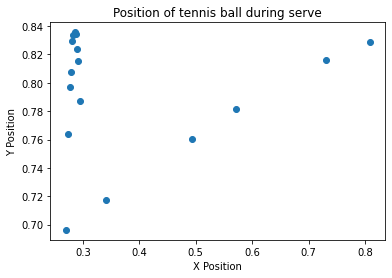

In [ ]:
plt.title("Position of tennis ball during serve")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.scatter(coord_x, coord_y)
plt.savefig("serve_position_x_y.png")

To determine the speed, let's look at the distance the ball travels over time:

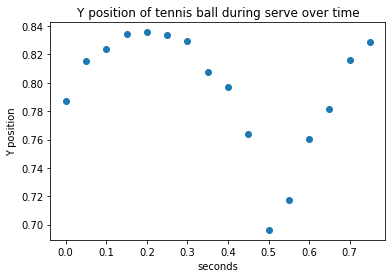

In [ ]:
plt.title("Y position of tennis ball during serve over time")
plt.xlabel("seconds")
plt.ylabel("Y position")
plt.scatter(timestamps, coord_y)
plt.savefig("ball_position_over_time.png")

You can see that 0.5 to 0.7 seconds is when the ball has been hit and is traveling across the court. So, to compute the speed, let's divide distance by time!

In [ ]:
# Get the first data point from 0.5 seconds
start_x = coord_x[timestamps.index(0.5)]
end_x = coord_x[-1]
start_y = coord_y[timestamps.index(0.5)]
end_y = coord_y[-1]

# Compute the Euclidean distance
distance = math.sqrt((start_x - end_x)**2 + (start_y - end_y)**2)
time = timestamps[-1] - 0.5

print(f"The speed of your serve was {distance/time}")

The speed of your serve was 2.2223250793599263
